In [5]:
polish_dictionary = {}
with open("morfologik.txt") as f:
    for line in f.readlines():
        base_word, flex_form, meta = line.split(";")
        polish_dictionary[flex_form.lower()] = base_word
        
print(len(polish_dictionary))

4623718


In [6]:
import regex
word_pattern = "\p{Letter}{2,}"

In [7]:
FILE_LIST = "files.pickle"
DATA_DIR = "/run/media/maciej/Nowy/data/json/"
CHOSEN_YEAR = "2011"

In [8]:
import os, json

import pickle
from tqdm import tqdm
from collections import defaultdict

words_with_counts = defaultdict(lambda: 0)

def load_data():    
    files = pickle.load(open(FILE_LIST, 'rb'))
    for file in tqdm(files):
        if file.startswith("judgment"):
            file_path = os.path.join(DATA_DIR, file)

            with open(file_path, 'r') as f:
                data = json.load(f)
                judgments = [x["textContent"] for x in data["items"] if x["judgmentDate"].startswith(CHOSEN_YEAR)]

            for judgment in judgments:
                judgment = regex.sub("<.*?>", "", judgment)
                
                for match in regex.finditer(word_pattern, judgment):
                    [word] = match.captures()
                    words_with_counts[word.lower()] += 1
load_data()
print(len(words_with_counts))


100%|██████████| 68/68 [00:15<00:00,  4.33it/s]


In [9]:
def sort_by_frequency(words, top=10):
    return sorted(words.items(), key=lambda x: x[1], reverse=True)[:top]

In [26]:
reduced_words_with_counts = sort_by_frequency(words_with_counts, top=1000) 

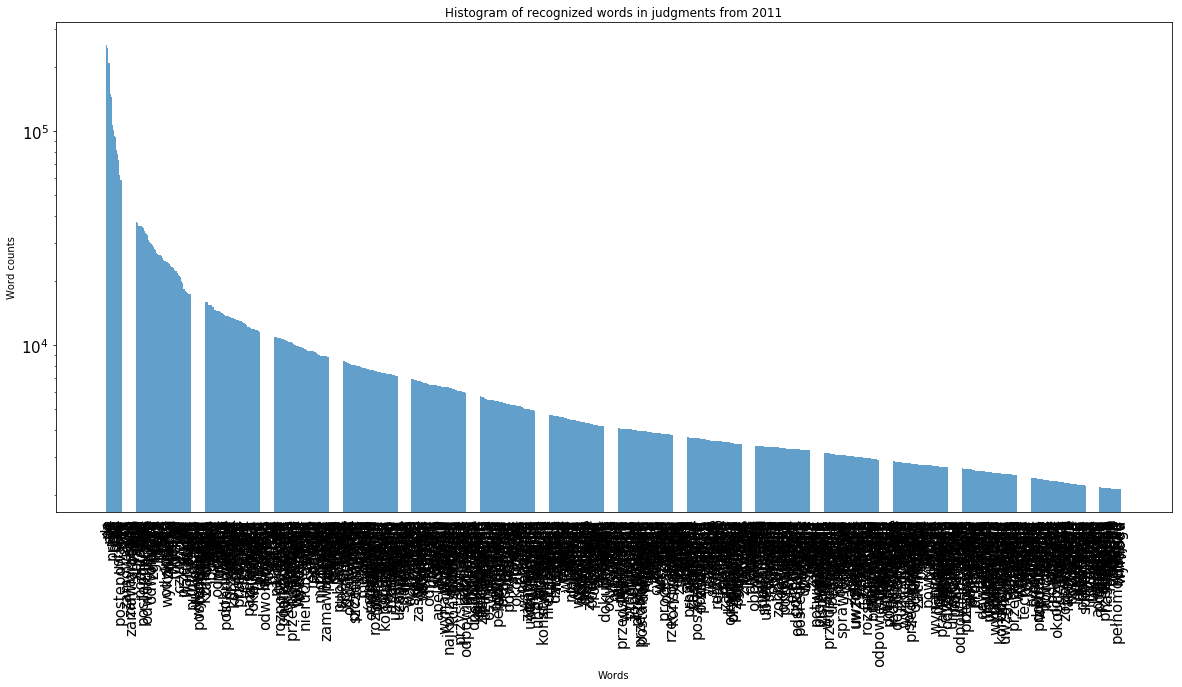

In [31]:
import matplotlib.pyplot as plt

words, word_counts = zip(*reduced_words_with_counts)
plt.bar(words, word_counts, alpha=0.7, log=True)
plt.xlabel('Words')
plt.ylabel('Word counts')
plt.yscale('log')
plt.title('Histogram of recognized words in judgments from 2011')

plt.rcParams['ytick.labelsize'] = 15 
plt.rcParams["figure.figsize"] = (20, 9)

plt.tick_params(
    axis='x',              
    which='both',      
    bottom=False, 
)
plt.xticks(rotation=90)

plt.show()

In [12]:
polish_words = {}
not_recognized = {}

for word, counts in words_with_counts.items():
    if word in polish_dictionary:
        polish_words[word] = counts
    else:
        not_recognized[word] = counts

In [13]:
from pprint import pprint
print("Top 10 recognized Polish words: ")
pprint(sort_by_frequency(polish_words))


Top 10 recognized Polish words: 
[('na', 253290),
 ('do', 244364),
 ('nie', 208698),
 ('art', 207198),
 ('że', 149133),
 ('przez', 143483),
 ('ust', 106139),
 ('się', 101380),
 ('dnia', 94506),
 ('jest', 93871)]


In [42]:
print("Top 30 words, which were not recognized: ")
top_unrecognized_words = sort_by_frequency(not_recognized, top=30)
pprint(top_unrecognized_words)

Top 30 words, which were not recognized: 
[('pzp', 35834),
 ('siwz', 26388),
 ('sygn', 26215),
 ('zw', 11099),
 ('ssn', 6102),
 ('otk', 4902),
 ('iv', 4493),
 ('lex', 4430),
 ('zu', 4359),
 ('sa', 3852),
 ('csk', 3562),
 ('uzp', 3035),
 ('osnc', 2752),
 ('sk', 2736),
 ('czp', 2219),
 ('ppkt', 2043),
 ('niepubl', 1987),
 ('ckn', 1923),
 ('osnp', 1906),
 ('uokik', 1895),
 ('vi', 1715),
 ('uk', 1657),
 ('późn', 1647),
 ('pln', 1537),
 ('poland', 1530),
 ('zd', 1525),
 ('publ', 1473),
 ('asseco', 1205),
 ('xvii', 983),
 ('impel', 955)]


In [51]:
def levenshtein_family(word, distance, alphabet):
    family = set()

    def find_family(word, distance):
        if distance == 0:
            family.add(word)
            return
        distance -= 1
        
        # replace characters
        for i in range(len(word) - 1):
            find_family(
                word=word[0:i] + word[i + 1] + word[i] + word[i + 2:],
                distance=distance,
            )

        # remove characters
        for i in range(len(word)):
            find_family(
                word=word[0:i] + word[i + 1:],
                distance=distance,
            )

        # insert characters
        for i in range(len(word) + 1):
            for character in alphabet:
                find_family(
                    word=word[:i] + character + word[i:],
                    distance=distance
                )

    find_family(word, distance)

    return family


In [48]:
import string

alphabet = list(string.ascii_lowercase + "ąćęłóżźśń")
print(alphabet)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ą', 'ć', 'ę', 'ł', 'ó', 'ż', 'ź', 'ś', 'ń']


In [58]:
def find_correction(word):
    max_lev_distance = 3
    
    for distance in range(1, max_lev_distance):
        possible_corrections = levenshtein_family(
            word=word,
            distance=distance,
            alphabet=alphabet,
        )
        possible_corrections = [correction for correction in possible_corrections if correction in polish_dictionary]
        if possible_corrections:
            possible_corrections.sort(key=lambda word: polish_words.get(word, 0), reverse=True)
            return possible_corrections[0]
        
    return ""

In [63]:
for unrecognized_word, _ in top_unrecognized_words:
    correction = find_correction(unrecognized_word)
    correction = correction if correction else "not found"
    print("{} -> {}".format(unrecognized_word.ljust(10, " "), correction))
    

pzp        -> pp
siwz       -> siw
sygn       -> syn
zw         -> tzw
ssn        -> sn
otk        -> tk
iv         -> hiv
lex        -> le
zu         -> zus
sa         -> sam
csk        -> ck
uzp        -> uz
osnc       -> on
sk         -> osk
czp        -> cz
ppkt       -> pkt
niepubl    -> not found
ckn        -> ck
osnp       -> osp
uokik      -> oki
vi         -> via
uk         -> ku
późn       -> późno
pln        -> pn
poland     -> polan
zd         -> dz
publ       -> pub
asseco     -> not found
xvii       -> ii
impel      -> wimpel
